In [1]:
import scipy.io, math, os
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from utils import *
import random

In [2]:
from tslearn.barycenters import \
    euclidean_barycenter, \
    dtw_barycenter_averaging, \
    dtw_barycenter_averaging_subgradient, \
    softdtw_barycenter
from tslearn.datasets import CachedDatasets
import dtw
from scipy.spatial.distance import euclidean

In [3]:
def get_pos_list(position, dimension, file_number, starting_point, end_point):
    values = []
    if dimension == 'x':
        dim = 0
    elif dimension == 'y':
        dim = 1 
    elif dimension == 'z':
        dim = 2
    else:
        raise ValueError

    if position == 'UL':
        for i in range(end_point - starting_point):
            coordinate = (UL_df[file_number][dim][starting_point + i])
            if str(coordinate) != 'nan':
                values.append(coordinate)
            
    if position == 'LL':
        for i in range(end_point - starting_point):
            coordinate = (LL_df[file_number][dim][starting_point + i])
            if str(coordinate) != 'nan':
                values.append(coordinate)
            
    if position == 'JW':
        for i in range(end_point - starting_point):
            coordinate = (JW_df[file_number][dim][starting_point + i])
            if str(coordinate) != 'nan':
                values.append(coordinate)
            
    if position == 'TB':
        for i in range(end_point - starting_point):
            coordinate = (TB_df[file_number][dim][starting_point + i])
            if str(coordinate) != 'nan':
                values.append(coordinate)
            
    if position == 'TD':
        for i in range(end_point - starting_point):
            coordinate = (TD_df[file_number][dim][starting_point + i])
            if str(coordinate) != 'nan':
                values.append(coordinate)
            
    if position == 'TT':
        for i in range(end_point - starting_point):
            coordinate = (TT_df[file_number][dim][starting_point + i])
            if str(coordinate) != 'nan':
                values.append(coordinate)
        
    return values

In [54]:
# function to find the dtw barycenter average
def plot_dba(word, position, gamma_val=1, only_plot_dba=False, try_custom=False):
    indexes = word_instances[word]
    all_values = []
    
    for number in indexes:
        #plot the originial trajectories
        if not only_plot_dba:
            plt.plot(frames[number][position][0], label = str(number))
        
        # create a list of the trajectories for the dba
        all_values.append(frames[number][position][0])
        filtered_values = [x for x in all_values if x != []]
        
    dba_soft = softdtw_barycenter(filtered_values, gamma=gamma_val)
    plt.plot(dba_soft, label = 'dba soft', linestyle = 'dashed')
    
    if try_custom:
        sensors = ['ULx', 'ULy', 'LLx', 'LLy', 'JWx', 'JWy', 'TDx', 'TDy', 'TBx', 'TBy', 'TTx', 'TTy']
        pos = sensors.index(position)
        custom_dtw = get_custom_dba(word, pos)
        plt.plot(custom_dtw, label = 'custom_dtw', linestyle = 'dotted')
    
    plt.title(word + ', ' + position)
    plt.legend()
    plt.show()

In [5]:
def get_custom_dba(word, sensor_number):
    done = False
    repetitions = {}
    indexes = word_instances[word]
    
    for i, index in enumerate(indexes):
        x = []
        for sensor in ['UL', 'LL', 'JW', 'TD', 'TB', 'TT']:
            x.append(np.stack([frames[index][sensor+'x'][0],frames[index][sensor+'y'][0]])) 
        # 0:ULx, 1:ULy, 2:LLx, 3:LLy etc
        x = np.concatenate(x).T
        repetitions[i] = x
    
    if len(repetitions) == 1:
        return repetitions[0]
    while done == False:
        new_signals = {}
        dist, cost_matrix, acc_cost_matrix, path = dtw.accelerated_dtw(repetitions[0], repetitions[1], dist=euclidean)
        new_signals[0] = repetitions[0][path[0]]
        new_signals[1] = repetitions[1][path[0]]

        for i in range(2, len(repetitions)):
            dist, cost_matrix, acc_cost_matrix, path = dtw.accelerated_dtw(repetitions[i], new_signals[i-1], dist=euclidean)
            new_signals[i]   = repetitions[i][path[0]]
            #new_signals[i+1] = repetitions[i+1][path[0]]
        
        repetitions = new_signals
        
        length = len(repetitions[0])
        if all(len(lst) == length for lst in repetitions.values()):
            done = True
    
    trajectory = []
    for i in range(len(repetitions)):
        x = []
        for values in repetitions[i]:
            x.append(values[sensor_number])
            
        trajectory.append(x)
    
    avg_trajectory = np.mean(trajectory, axis=0)
        
    return avg_trajectory


In [6]:
def get_dba(word, position, gamma_val=1):
    indexes = word_instances[word]
    all_values = []
    
    for number in indexes:
        
        # create a list of the trajectories for the dba
        all_values.append(frames[number][position][0])
        filtered_values = [x for x in all_values if x != []]
        
    dba_soft = softdtw_barycenter(filtered_values, gamma=gamma_val)
    dba      = dtw_barycenter_averaging(filtered_values)
    
    return dba_soft

In [7]:
directory = 'data/Data/F1/mat'
counter = 1
UL_df, LL_df, JW_df, TD_df, TB_df, TT_df = [], [], [], [], [], []

for filename in sorted(os.listdir(directory)):
    if filename.endswith('.mat'):
        f = os.path.join(directory, filename)
        mat = scipy.io.loadmat(f)
        # takes the data that is stored at the key that precedes the data for each .mat file
        data = mat['usctimit_ema_f1_{:03}_{:03}'.format(counter, counter + 4)]
        counter += 5

        # make dataframes of the six positions
        UL_df.append(pd.DataFrame.from_dict(data[0][1][2]))
        LL_df.append(pd.DataFrame.from_dict(data[0][2][2]))
        JW_df.append(pd.DataFrame.from_dict(data[0][3][2]))
        TD_df.append(pd.DataFrame.from_dict(data[0][4][2]))
        TB_df.append(pd.DataFrame.from_dict(data[0][5][2]))
        TT_df.append(pd.DataFrame.from_dict(data[0][6][2]))

In [8]:
frames = {}

with open('timestamps.txt', 'r') as file:
    timestamps = file.read().splitlines()
    for word_number, line in enumerate(timestamps):
        split_line = line.split(',')
        sent_number = int(split_line[-1])
        
        # find start and end by multiplying the timestamps with the sampling rate
        starting_point = math.floor(float(split_line[2]) * get_srate(int(split_line[0])))
        end_point = math.ceil(float(split_line[3]) * get_srate(int(split_line[0])))
        
        # make dataframe for each word, so 3481 dataframes
        # this is different from the one in main.ipynb, since it looks at x an y seperately, and 
        # ignores the z values. still need to properly motivate this.
        # TODO: make this more efficient 
        data = {'word' : [split_line[1]],
                'srate': [get_srate(int(split_line[0]))],
                'sent' : [int(split_line[-1])],
                'ULx'  : [get_pos_list('UL', 'x', int(split_line[0]), starting_point, end_point)],
                'ULy'  : [get_pos_list('UL', 'y', int(split_line[0]), starting_point, end_point)],
                'LLx'  : [get_pos_list('LL', 'x', int(split_line[0]), starting_point, end_point)],
                'LLy'  : [get_pos_list('LL', 'y', int(split_line[0]), starting_point, end_point)],
                'JWx'  : [get_pos_list('JW', 'x', int(split_line[0]), starting_point, end_point)],
                'JWy'  : [get_pos_list('JW', 'y', int(split_line[0]), starting_point, end_point)],
                'TDx'  : [get_pos_list('TD', 'x', int(split_line[0]), starting_point, end_point)],
                'TDy'  : [get_pos_list('TD', 'y', int(split_line[0]), starting_point, end_point)],
                'TBx'  : [get_pos_list('TB', 'x', int(split_line[0]), starting_point, end_point)],
                'TBy'  : [get_pos_list('TB', 'y', int(split_line[0]), starting_point, end_point)],
                'TTx'  : [get_pos_list('TT', 'x', int(split_line[0]), starting_point, end_point)],
                'TTy'  : [get_pos_list('TT', 'y', int(split_line[0]), starting_point, end_point)]}
        
        df = pd.DataFrame(data)
        frames[word_number] = df

In [9]:
word_instances = {}

for frame in frames:
    # continues if the instances of this word have already been found
    if frames[frame]['word'][0] in word_instances:
        continue
    
    # saves all the key numbers of instances of the words
    word_instances[frames[frame]['word'][0]] = get_key(frames[frame]['word'][0], frames)

In [10]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [11]:
frames_after_dtw = {}
word_list = []
# sensors = ['ULx', 'ULy', 'LLx', 'LLy', 'JWx', 'JWy', 'TDx', 'TDy', 'TBx', 'TBy', 'TTx', 'TTy']

for key, value in frames.items():
    word = value['word'][0]
    
    if word not in word_list:
        # TODO: make this more efficient 
        # for sensor in sensors:
        #     data = {}
        #     data[sensor] = get_dba(word, sensor)
        data = {'ULx'  : [get_dba(word, 'ULx')],
                'ULy'  : [get_dba(word, 'ULy')],
                'LLx'  : [get_dba(word, 'LLx')],
                'LLy'  : [get_dba(word, 'LLy')],
                'JWx'  : [get_dba(word, 'JWx')],
                'JWy'  : [get_dba(word, 'JWy')],
                'TDx'  : [get_dba(word, 'TDx')],
                'TDy'  : [get_dba(word, 'TDy')],
                'TBx'  : [get_dba(word, 'TBx')],
                'TBy'  : [get_dba(word, 'TBy')],
                'TTx'  : [get_dba(word, 'TTx')],
                'TTy'  : [get_dba(word, 'TTy')]}
    
        df = pd.DataFrame(data)
        frames_after_dtw[word] = df
        word_list.append(word)    

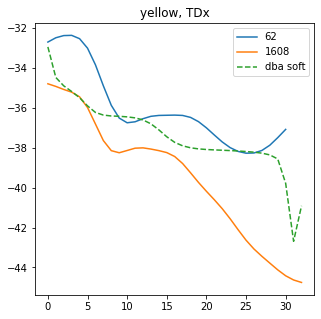

In [55]:
plt.rcParams['figure.figsize'] = [5, 5]
plot_dba('yellow', 'TDx', only_plot_dba=False, try_custom=False)

In [20]:
rep1 = 62
rep2 = 1608
x1, x2 = [], []
for sensor in ['UL', 'LL', 'JW', 'TD', 'TB', 'TT']:
    x1.append(np.stack([frames[rep1][sensor+'x'][0],frames[rep1][sensor+'y'][0]]))
    x2.append(np.stack([frames[rep2][sensor+'x'][0],frames[rep2][sensor+'y'][0]]))
x1 = np.concatenate(x1).T # 0:ULx, 1:ULy, 2:LLx, 3:LLy etc
x2 = np.concatenate(x2).T

dist, cost_matrix, acc_cost_matrix, path = dtw.accelerated_dtw(x1, x2, dist=euclidean)
# plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
# plt.plot(path[0], path[1], 'w')
# plt.show()

# print(dist)
x1_new = x1[path[0]]
x2_new = x2[path[1]]

avg_trajectory= np.mean([x1_new, x2_new], axis=0)

UL = []
for values in avg_trajectory:
    ULavg = values[0]
    UL.append(ULavg)